In [ ]:

# stratified sampling
# assigning class weights
# train isolation forest
# train LSTM model
# 3 way decision

In [ ]:

import pandas as pd

# Load the dataset
df = pd.read_csv('/content/reduced_CIC-IDS2017.csv')

attack_types = df['label'].unique()

print("Attack types present in the dataset:")
for attack in attack_types :
  print(attack)


<ipython-input-4-e004168cf73b>:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/reduced_CIC-IDS2017.csv')


Attack types present in the dataset:
Benign
nan


In [ ]:

for attack in attack_types:
  print(f"- {attack}")

attack_counts = df['label'].value_counts()

print("\nNumber of samples for each attack type:")
attack_counts


- Benign
- nan

Number of samples for each attack type:


,count
label,
Benign,271185


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Streaming output truncated to the last 5000 lines.
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Pr

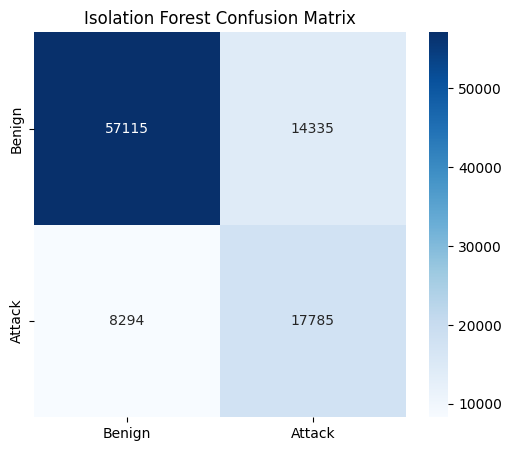


LSTM Performance on IF-Predicted Attacks:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14335
           1       0.99      1.00      0.99     17785

    accuracy                           0.99     32120
   macro avg       0.99      0.99      0.99     32120
weighted avg       0.99      0.99      0.99     32120

Confusion Matrix:
[[14138   197]
 [   88 17697]]


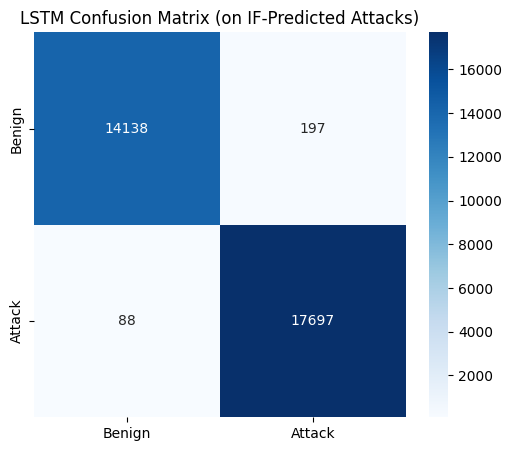

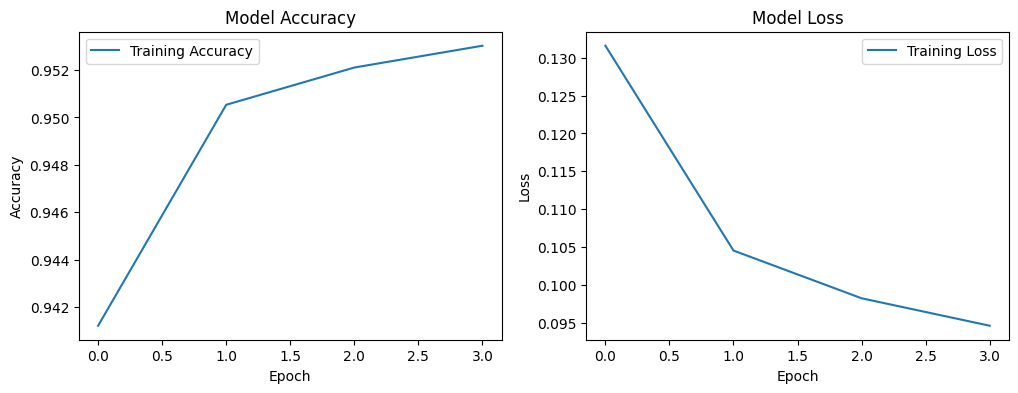


3-Way Decision Framework Results:
Class counts: {0: 'Normal', 1: 'Attack', 2: 'Uncertain'}
Distribution: {0: np.int64(65409), 1: np.int64(17857), 2: np.int64(14263)}

Performance on Definite Predictions (Normal/Attack):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     57294
           1       0.99      0.68      0.81     25972

    accuracy                           0.90     83266
   macro avg       0.93      0.84      0.87     83266
weighted avg       0.91      0.90      0.89     83266

Confusion Matrix:
[[57115   179]
 [ 8294 17678]]


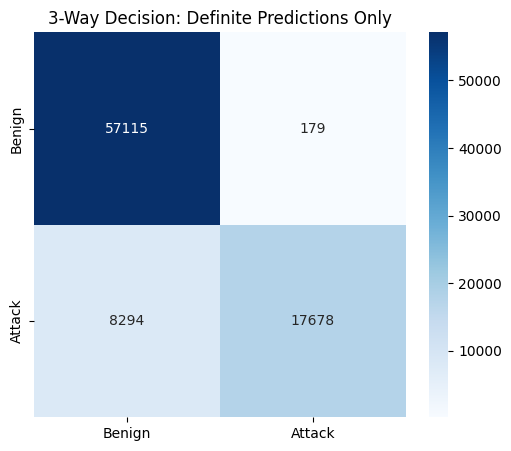


Analysis of Uncertain Points:
Actual labels in uncertain points:
0    14156
1      107
Name: count, dtype: int64


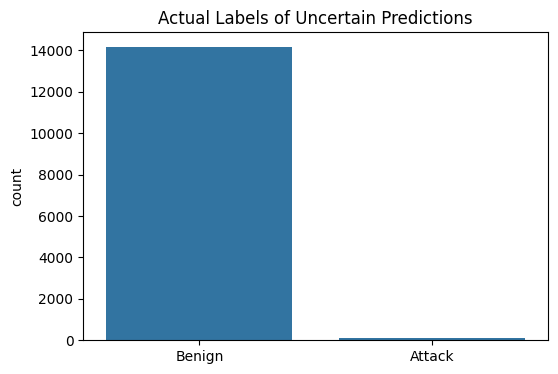


0.41% of actual attacks were classified as uncertain
19.81% of actual benign were classified as uncertain


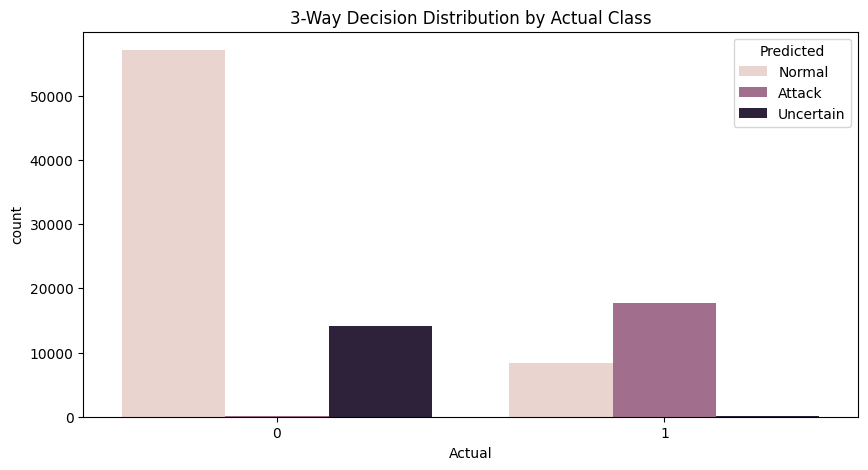

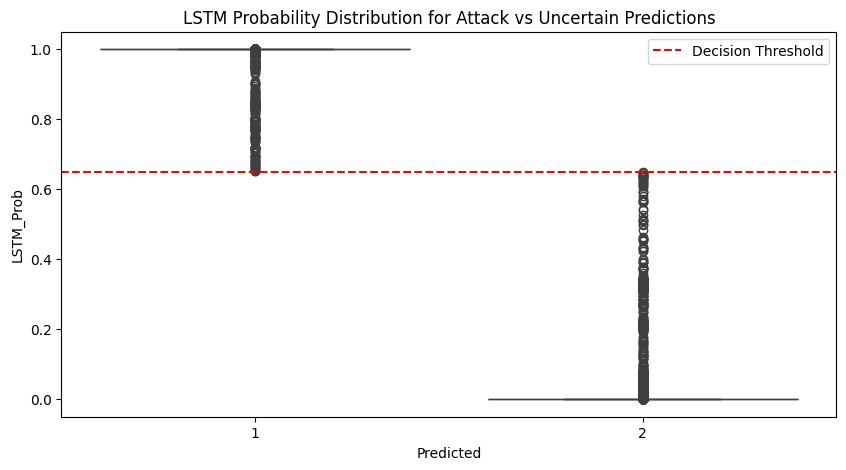

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Load and preprocess data
df = pd.read_csv("reduced_CIC-IDS2017.csv")
df.dropna(inplace=True)
df["label"] = df["label"].apply(lambda x: 0 if x == "Benign" else 1)
df.drop(columns=["flow_id", "timestamp", "src_ip", "dst_ip"], inplace=True)
df["protocol"] = df["protocol"].apply(lambda x: 0 if x == "TCP" else 1)

# Split features and labels
X = df.drop(columns=["label"]).values
y = df["label"].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Reshape for LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 1: Train LSTM on original imbalanced data with class weights
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_train.shape[1])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])
lstm_model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
history = lstm_model.fit(X_train_lstm, y_train,
                        epochs=4,
                        batch_size=64,
                        class_weight=class_weight_dict)

# Step 2: Train Isolation Forest on benign data only
benign_mask = y_train == 0
iso_forest = IsolationForest(contamination=0.20, random_state=42)
iso_forest.fit(X_train[benign_mask])  # Train ONLY on benign samples

# Step 3: Get IF's predictions on test set
X_test_2d = X_test.reshape(X_test.shape[0], -1)  # Flatten for IF
test_iso_preds = iso_forest.predict(X_test_2d)

# Convert IF predictions: 1=normal, -1=anomaly to 0=normal, 1=attack
test_iso_labels = np.where(test_iso_preds == 1, 0, 1)

print("\nActual vs Predicted labels (Isolation Forest):")
for actual, pred in zip(y_test, test_iso_labels):
    print(f"Actual: {actual}, Predicted: {pred}")

# Step 4: Print normal points predicted by IF
normal_mask = test_iso_labels == 0
print(f"\nNumber of normal points predicted by IF: {sum(normal_mask)}")
print(f"Number of attack points predicted by IF: {sum(test_iso_labels)}")

# Step 5: Send only IF-predicted attacks to LSTM for re-prediction
attack_mask = test_iso_labels == 1
X_test_attacks = X_test_lstm[attack_mask]  # Only IF-predicted attacks (3D)
y_test_attacks = y_test[attack_mask]

if len(X_test_attacks) > 0:
    lstm_probs = lstm_model.predict(X_test_attacks).flatten()
    y_pred_lstm = (lstm_probs > 0.5).astype(int)
else:
    lstm_probs = np.array([])
    y_pred_lstm = np.array([])

print("\nActual vs Predicted labels (LSTM on IF-Predicted Attacks):")
for actual, pred in zip(y_test_attacks, y_pred_lstm.flatten()):
    print(f"Actual: {actual}, Predicted: {pred}")

# Step 6: Evaluation - Confusion Matrix for Isolation Forest
print("\nIsolation Forest Performance:")
print(classification_report(y_test, test_iso_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_iso_labels))
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, test_iso_labels),
            annot=True, fmt='d',
            cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title('Isolation Forest Confusion Matrix')
plt.show()

# Step 7: Evaluation - Confusion Matrix for LSTM (only on IF-predicted attacks)
if len(y_pred_lstm) > 0:
    print("\nLSTM Performance on IF-Predicted Attacks:")
    print(classification_report(y_test_attacks, y_pred_lstm))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_attacks, y_pred_lstm))
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test_attacks, y_pred_lstm),
                annot=True, fmt='d',
                cmap='Blues',
                xticklabels=['Benign', 'Attack'],
                yticklabels=['Benign', 'Attack'])
    plt.title('LSTM Confusion Matrix (on IF-Predicted Attacks)')
    plt.show()
else:
    print("\nNo attack points predicted by IF for LSTM to evaluate")

# Step 8: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Step 9: Implement 3-Way Decision Framework
def three_way_decision(iso_preds, lstm_preds, lstm_probs, uncertainty_threshold=0.3):
    """
    Combine Isolation Forest and LSTM predictions into 3-way decision:
    - Normal (0): IF predicts normal
    - Attack (1): IF predicts attack AND LSTM predicts attack with high confidence
    - Uncertain (2): IF predicts attack BUT LSTM predicts normal OR low confidence

    Parameters:
        iso_preds: Isolation Forest predictions (0=normal, 1=attack)
        lstm_preds: LSTM predictions (0=normal, 1=attack)
        lstm_probs: LSTM predicted probabilities (for confidence)
        uncertainty_threshold: Probability threshold for uncertainty

    Returns:
        Array of final predictions (0=normal, 1=attack, 2=uncertain)
    """
    final_preds = np.zeros_like(iso_preds)
    attack_indices = np.where(iso_preds == 1)[0]

    for i in range(len(iso_preds)):
        if iso_preds[i] == 0:  # IF says normal
            final_preds[i] = 0  # Normal
        else:  # IF says attack
            if len(lstm_preds) > 0 and i in attack_indices:
                idx = np.where(attack_indices == i)[0][0]
                if lstm_preds[idx] == 1 and lstm_probs[idx] > (0.5 + uncertainty_threshold/2):
                    final_preds[i] = 1  # Confident attack
                else:
                    final_preds[i] = 2  # Uncertain
            else:
                final_preds[i] = 2  # Uncertain (no LSTM prediction available)

    return final_preds

# Apply 3-way decision
final_predictions = three_way_decision(test_iso_labels,
                                     y_pred_lstm.flatten() if len(y_pred_lstm) > 0 else np.array([]),
                                     lstm_probs)

# Step 10: Evaluate 3-Way Decision
print("\n3-Way Decision Framework Results:")
print("Class counts:", {0: "Normal", 1: "Attack", 2: "Uncertain"})
print("Distribution:", {0: sum(final_predictions == 0),
                       1: sum(final_predictions == 1),
                       2: sum(final_predictions == 2)})

# For points with definite predictions (normal or attack)
definite_mask = final_predictions != 2
if sum(definite_mask) > 0:
    print("\nPerformance on Definite Predictions (Normal/Attack):")
    print(classification_report(y_test[definite_mask], final_predictions[definite_mask]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test[definite_mask], final_predictions[definite_mask]))

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test[definite_mask], final_predictions[definite_mask]),
                annot=True, fmt='d',
                cmap='Blues',
                xticklabels=['Benign', 'Attack'],
                yticklabels=['Benign', 'Attack'])
    plt.title('3-Way Decision: Definite Predictions Only')
    plt.show()

# For uncertain points
uncertain_mask = final_predictions == 2
if sum(uncertain_mask) > 0:
    print("\nAnalysis of Uncertain Points:")
    uncertain_actuals = y_test[uncertain_mask]
    print("Actual labels in uncertain points:")
    print(pd.Series(uncertain_actuals).value_counts())

    # Plot distribution of actual labels in uncertain predictions
    plt.figure(figsize=(6, 4))
    sns.countplot(x=uncertain_actuals)
    plt.xticks([0, 1], ['Benign', 'Attack'])
    plt.title('Actual Labels of Uncertain Predictions')
    plt.show()

    # Calculate what percentage of attacks were pushed to uncertain
    total_attacks = sum(y_test == 1)
    attacks_in_uncertain = sum((y_test == 1) & (final_predictions == 2))
    print(f"\n{attacks_in_uncertain/total_attacks:.2%} of actual attacks were classified as uncertain")

    # Calculate what percentage of benign were pushed to uncertain
    total_benign = sum(y_test == 0)
    benign_in_uncertain = sum((y_test == 0) & (final_predictions == 2))
    print(f"{benign_in_uncertain/total_benign:.2%} of actual benign were classified as uncertain")

# Step 11: Visualize the 3-Way Decision Results
decision_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': final_predictions,
    'Isolation_Forest': test_iso_labels,
    'LSTM_Prob': np.nan  # Initialize with NaN
})

# Fill LSTM probabilities where available
if len(lstm_probs) > 0:
    attack_indices = np.where(test_iso_labels == 1)[0]
    for i, prob in zip(attack_indices, lstm_probs):
        if i < len(decision_df):
            decision_df.at[i, 'LSTM_Prob'] = prob

# Plot distribution of predictions
plt.figure(figsize=(10, 5))
sns.countplot(x='Actual', hue='Predicted', data=decision_df)
plt.title('3-Way Decision Distribution by Actual Class')
plt.legend(title='Predicted', labels=['Normal', 'Attack', 'Uncertain'])
plt.show()

# Plot LSTM probabilities for uncertain vs attack decisions
if len(lstm_probs) > 0:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Predicted', y='LSTM_Prob', data=decision_df[decision_df['Predicted'].isin([1, 2])])
    plt.title('LSTM Probability Distribution for Attack vs Uncertain Predictions')
    plt.axhline(y=0.5 + 0.3/2, color='r', linestyle='--', label='Decision Threshold')
    plt.legend()
    plt.show()